# Data Science a Distancia - CN17
# TP Final - Análisis de series de tiempo 

## Grupo Nro. 12
## Integrantes:
    * Torres Moray, Agustina        
    * Procopio, Eda

## Introducción

A partir de dos archivos con datos de ventas de medicamentos en Argentina de los últimos años (2016-2023), armamos un dataset con datos correspondientes a un grupo terapéutico para analizar las ventas de unidades a lo largo del tiempo. 

## Listado de Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from scipy import stats
from statistics import mode

from sklearn.model_selection import train_test_split

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model  import ARIMA

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

## Declaración de constantes

In [2]:
columna = 'Nivel de Clase Terapeutica 2'  #Nombre de columna (grupo terapeutico) en archivo formato actual 
columna_anterior = 'CLASS2_COD'           #Nombre de columna (grupo terapeutico) en archivo formato anterior 
c_grupo_terapeutico = 'N05'               #Grupo terápeutico seleccionado (psicodelpitocso)  

## Definición de módulos de funciones

In [3]:
# Función para leer archivo CSV------------------------------------------------------------------------------------#
# Parámetros de entrada:
#   name: Nombre del archivo
#   sep:  Caracter separador de columnas
#   tipo: A (formato  anterior de archivo correspondiente a periodos junio 2016 - abril 2018 ) ó 
#         B (formato nuevo de archivo nuevo corrspondiente a periodos mayo 2018 - abril 2023)
# Parámetros de salida:
#   df:   dataset que contiene los datos leidos del archivo
def leer_archivo(name,sep,tipo):
    if tipo == 'A':
        df = pd.read_csv(name,sep=sep,dtype = {"periodo":str, 'UNIDADES': str}, dayfirst = True,encoding = 'latin-1')
    elif tipo == 'B':
        df = pd.read_csv(name,sep=sep,dtype = {'periodo':str, 'UNIDADES': int}, encoding='utf-8-sig')
    return df

# Función para preparar dataset------------------------------------------------------------------------------------#
# Filtra los datos del dataset df (columna = filtro), Agrupa las ventas por el atributo 'periodo' y crea un índice 
# sobre dicho atributo para indicar la fecha que se usa en la serie de tiempo. Las unidades en dataset de salida 
# estarán expresadas en miles de unidades. Trabaja con dos tipos de formato de archivo (A y B).
# Parámetros de entrada:
#     df:        dataset que contiene los datos a procesar
#     columna:   Columnna sobre la cual se filtrarán los datos 
#     filtro:    Valor que se usará para filtrar los datos
#     tipo:      Tipo de archivo. Recibe dos valores A o B. Donde A: formato actual y B: formato anterior
# Parámetros de salida:
#     df_ventas: dataset ya filtrado, con ventas agrupadas por periodo, unidades expresadas en miles de unidades
#                y con nuevo indice 'periodo'
def preparar_datos(df,columna,filtro,tipo):
    
    df_ventas = df.loc[df[columna] == filtro]
    print('Cantidad reg Filtro:',df_ventas.shape)    
    
    if tipo == 'A':   
        df_ventas.periodo = df_ventas.periodo.astype(str)
        df_ventas.periodo = df_ventas.periodo.apply(lambda x: pd.to_datetime(str(x),format='%m.%Y'))    
        df_ventas.USD = df_ventas.USD.apply( lambda x: x.split(',')[0])
        df_ventas.USD = df_ventas.USD.apply( lambda x: x.replace('.',''))
        df_ventas.USD = df_ventas.USD.astype(np.float)     
        df_ventas.UNIDADES = df_ventas.UNIDADES.apply( lambda x: x.replace('.',''))
        df_ventas.UNIDADES = df_ventas.UNIDADES.astype(np.float64)   
        df_ventas.UNIDADES = df_ventas.UNIDADES / 1000    
        df_ventas = df_ventas.groupby('periodo')['UNIDADES'].sum().reset_index()
        df_ventas = df_ventas.set_index('periodo')      
        df_ventas = df_ventas['UNIDADES'].resample('MS').mean().to_frame()
    elif tipo == 'B':
        df_ventas.periodo = df_ventas.periodo.astype(str)
        df_ventas.periodo = df_ventas.periodo.apply(lambda x: pd.to_datetime(str(x)))  
        df_ventas.UNIDADES = df_ventas.UNIDADES.astype(np.float64)   
        df_ventas.UNIDADES = df_ventas.UNIDADES / 1000   
        df_ventas = df_ventas.groupby('periodo')['UNIDADES'].sum().reset_index()
        df_ventas = df_ventas.set_index('periodo')      
        df_ventas = df_ventas['UNIDADES'].resample('MS').mean().to_frame()                    
    return df_ventas

# Función para fusionar datos en dataset---------------------------------------------------------------#
# Parámetros de entrada:
#     df_ventas:          Dataset con las ventas (mayo 2018 - abril 2023)  (archivo tipo A)
#     df_ventas_anterior: Dataset con las ventas (junio 2016 - abril 2018) (archivo tipo B)
# Parámetros de salidad:
#     df_ventas:          Dataset que resulta de fusionar los dos dataset de entrada. Tiene además dos
#                         nueva columnas (timeIndex y timeIndex_sq) que utilizarán luego en los modelos
#                         de series de tiempo.
def fusionar_dataset(df_ventas,df_ventas_anterior):
    df_ventas = df_ventas.append(df_ventas_anterior)
    df_ventas = df_ventas.sort_values('periodo')    
    df_ventas["timeIndex"] = pd.Series(np.arange(len(df_ventas['UNIDADES'])), index=df_ventas.index)
    df_ventas["timeIndex_sq"] = df_ventas["timeIndex"]**2      
    return df_ventas

# Función para calcular raiz cuadrada del error cuadrático medio--------------------------------------#
# Parámetros de entrada:
# predicted:   Valores predichos por el modelo
#     actual:  Valores reales
# Parámetros de salida:
#     rmse:    Raiz del error cuadrático medio de los datos ingresados en los parámetros de entrada
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

# Función que plotea la serie------------------------------------------------------------------------#
def plot_df(df, x, y, title="", xlabel='Fecha', ylabel='Valor', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

# Función para graficar la serie de tiempo, el ACF, el PACF y el test de Dickey-Fuller---------------#
# Parámetros de entrada:
#     y:    Serie de tiempo
#     lags: Indica cuántos lags incluir para el cálculo de la ACF y PACF
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        
        # definimos ejes
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        
        # obtengo el p-value con h0: raiz unitaria presente
        p_value = sm.tsa.stattools.adfuller(y)[1]
        
        ts_ax.set_title('Análisis de la Serie de Tiempo\n Dickey-Fuller: p={0:.5f}'\
                        .format(p_value))
        
        # plot de autocorrelacion
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        # plot de autocorrelacion parcial
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()   
        
# Función para actualizar reporte de raiz cuadrático medio-----------------------------------------#
# Parámetros de entrada:
#     df_Results:      Dataset con los resultados error cuadrático medio de los modelos
#     etiqueta_modelo: Etiqueta con la se identificará al modelo en el reporte
#     valores_modelo:  Valores devueltos por el modelo para un rango de tiempo
#     valores_reales:  Valores reales de test para el mismo rango de tiempo
# Parámetros de salida: 
#     df_Results:      Dataset con un registro más 
def actualizar_reporte_resultados(df_Results,etiqueta_modelo,valores_modelo,valores_reales):
    cant_lineas = df_Results.shape[0]
    df_Results.loc[cant_lineas, "Model"] = etiqueta_modelo
    df_Results.loc[cant_lineas, "RMSE"] = RMSE(valores_modelo, valores_reales)
    return df_Results        

## Cuerpo principal del programa

In [4]:
# Leemos el archivo que contiene las ventas de medicamentos de Argentina desde Mayo 2018 y hasta Abril 2023
df          = leer_archivo('ventas.csv',';','A')

In [5]:
# Leemos el archivo que contiene las ventas de medicamentos de Argentina desde Junio 2016 a Abril 2018
df_anterior = leer_archivo('ventas_anterior.csv',';','B')

In [6]:
# Vemos los tipos de datos del archivo formato antiguo (junio 2016 - abril 2018)
df_anterior.dtypes

periodo         object
Product          int64
PROD_DES        object
Pack             int64
PACK_DES        object
CLASS1_COD      object
CLASS1_DES      object
CLASS2_COD      object
CLASS2_DES      object
CLASS3_COD      object
CLASS3_DES      object
CLASS4_COD      object
CLASS4_DES      object
Manufacturer     int64
MANU_DES        object
UNIDADES         int32
dtype: object

In [7]:
# Vemos los tipos de datos del archivo formato actual (mayo 2018 - abril 2023)
df.dtypes

periodo                           object
Nivel de Clase Terapeutica 1      object
Nivel de Clase Terapeutica 1.1    object
Nivel de Clase Terapeutica 2      object
Nivel de Clase Terapeutica 2.1    object
Nivel de Clase Terapeutica 3      object
Nivel de Clase Terapeutica 3.1    object
Laboratorio                       object
Laboratorio.1                     object
Producto                          object
Producto.1                        object
Pack                              object
Pack.1                            object
UNIDADES                          object
MONEDA_LOCAL                      object
USD                               object
dtype: object

In [8]:
# Miramos la cantidad de filas y columnas leias en el archivo con formato actual (mayo 2018 - abril 2023)
df.shape

(778296, 16)

In [9]:
# Miramos la cantidad de filas y columnas leias en el archivo con formato anterior (junio 2016 - abril 2018)
df_anterior.shape

(939412, 16)

In [10]:
# Observamos los primeros registros del dataset que tiene los últimos años de ventas (mayo 2018 - abril 2023)
df.head(3)

,periodo,Nivel de Clase Terapeutica 1,Nivel de Clase Terapeutica 1.1,Nivel de Clase Terapeutica 2,Nivel de Clase Terapeutica 2.1,Nivel de Clase Terapeutica 3,Nivel de Clase Terapeutica 3.1,Laboratorio,Laboratorio.1,Producto,Producto.1,Pack,Pack.1,UNIDADES,MONEDA_LOCAL,USD
0,05.2018,A,APARATO DIGEST Y METABOL,A01,ESTOMATOLOGICOS,A01A,ESTOMATOLOGICOS,LAA/1140,EUROFARMA,LAA/58456,NENE DENT EUF,LAA/5845601,NENE DENT GEL. 10 G x 1,10.260,"682.694,106641721","29.192,000000000"
1,05.2018,A,APARATO DIGEST Y METABOL,A01,ESTOMATOLOGICOS,A01A,ESTOMATOLOGICOS,LAA/1494,CABUCHI,LAA/16981,MUELITA FORTE C1B,LAA/1698101,MUELITA FORTE GEL FORTE 20 % 10 G x 1,7.550,"559.962,581852198","23.944,000000000"
2,05.2018,A,APARATO DIGEST Y METABOL,A01,ESTOMATOLOGICOS,A01A,ESTOMATOLOGICOS,LAA/1494,CABUCHI,LAA/57532,MUELITA C1B,LAA/5753201,MUELITA GEL. 10 G x 1 (ADLT),11.824,"769.013,096351731","32.883,000000000"


In [11]:
# Observamos los primeros registros del dataset que tiene los primeros años de ventas (Junio 2016 - Abril 2018)
df_anterior.head(3)

,periodo,Product,PROD_DES,Pack,PACK_DES,CLASS1_COD,CLASS1_DES,CLASS2_COD,CLASS2_DES,CLASS3_COD,CLASS3_DES,CLASS4_COD,CLASS4_DES,Manufacturer,MANU_DES,UNIDADES
0,20160601,1,FINDOL T.L,101,FINDOL SOBRES MONOD 4 G x 20,M,APARATO LOCOMOTOR,M01,ANIINFLAMAT Y ANTIRREUMA,M01A,ANTIRREUMAT NO ESTEROID,M01A1,ANTIRREUM NO ESTER SOLOS,8600,TEMIS LOSTALO,0
1,20160601,1,FINDOL T.L,101,FINDOL SOBRES MONOD 4 G x 20,M,APARATO LOCOMOTOR,M01,ANIINFLAMAT Y ANTIRREUMA,M01A,ANTIRREUMAT NO ESTEROID,M01A1,ANTIRREUM NO ESTER SOLOS,8600,TEMIS LOSTALO,0
2,20160601,1,FINDOL T.L,102,FINDOL SOBRES GRAN. 1500 MG 4 G x 30,M,APARATO LOCOMOTOR,M05,OTR.PROD.AFEC.APAR.LOCOM,M05X,OTR.PRD.MUSCULO-ESQUELET,M05X0,OTR.PRD.MUSCULO-ESQUELET,8600,TEMIS LOSTALO,1323


In [12]:
# Filtra los datos del dataset df (columna = filtro), Agrupa las ventas por el atributo 'periodo' y crea un índice sobre
# dicho atributo para indicar la fecha que se usa en la serie de tiempo. Las unidades en dataset de salida estarán 
# expresadas en miles de unidades. Le indicamos que los datos pasados por parámetro corresponden a archivo tipo A.
# (Mayo 2018 - Abril 2023)
df_ventas = preparar_datos(df,columna,c_grupo_terapeutico,'A')

Cantidad reg Filtro: (32135, 16)


In [13]:
# Filtra los datos del dataset df (columna = filtro), Agrupa las ventas por el atributo 'periodo' y crea un índice sobre
# dicho atributo para indicar la fecha que se usa en la serie de tiempo. Las unidades en dataset de salida estarán 
# expresadas en miles de unidades. Le indicamos que los datos pasados por parámetro corresponden a archivo tipo B.
# (Junio 2016 - Abril 2018)
df_ventas_anterior = preparar_datos(df_anterior,columna_anterior,c_grupo_terapeutico,'B')

Cantidad reg Filtro: (34316, 16)


In [14]:
# Observamos los primeros registros del dataset de ventas (Junio 2016 - Abril 2018)
df_ventas_anterior.head()

,UNIDADES
periodo,
2016-06-01,1833.352
2016-07-01,1857.225
2016-08-01,1924.707
2016-09-01,1662.422
2016-10-01,1773.876


In [15]:
# Observamos los últimos registros del dataset de ventas (Mayo 2018 - Abril 2023)
df_ventas.head()

,UNIDADES
periodo,
2018-05-01,1724.720
2018-06-01,1662.268
2018-07-01,1732.789
2018-08-01,1782.710
2018-09-01,1617.218


In [16]:
# Fusionamos en df_ventas los datos almacenados en df_ventas y df_ventas_anterior. Creamos además 2 nuevas columnas para
# luego modelar la serie de tiempo. Luego de este proceso el dataset df_ventas contendrá las ventas (junio 2016 a abril 2023).
df_ventas = fusionar_dataset(df_ventas,df_ventas_anterior)

In [17]:
# Vemos los primeros registros del dataset resultado de la fusión. Observamos que tienen las dos columnas nuevas
df_ventas.head()

,UNIDADES,timeIndex,timeIndex_sq
periodo,,,
2016-06-01,1833.352,0,0
2016-07-01,1857.225,1,1
2016-08-01,1924.707,2,4
2016-09-01,1662.422,3,9
2016-10-01,1773.876,4,16


In [18]:
# Observamos los tipos de datos del dataset ventas (junio 2016 a abril 2023)
df_ventas.dtypes

UNIDADES        float64
timeIndex         int32
timeIndex_sq      int32
dtype: object

In [19]:
df_ventas.shape

(83, 3)

In [20]:
# Preparamos los datos para unos primeros gráficos utilizados para explorar el dataset.
df_ventas['year'] = [d.year for d in df_ventas.index]
df_ventas['month'] = [d.strftime('%b') for d in df_ventas.index]
years = df_ventas['year'].unique()

# Preparamos los colores:
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

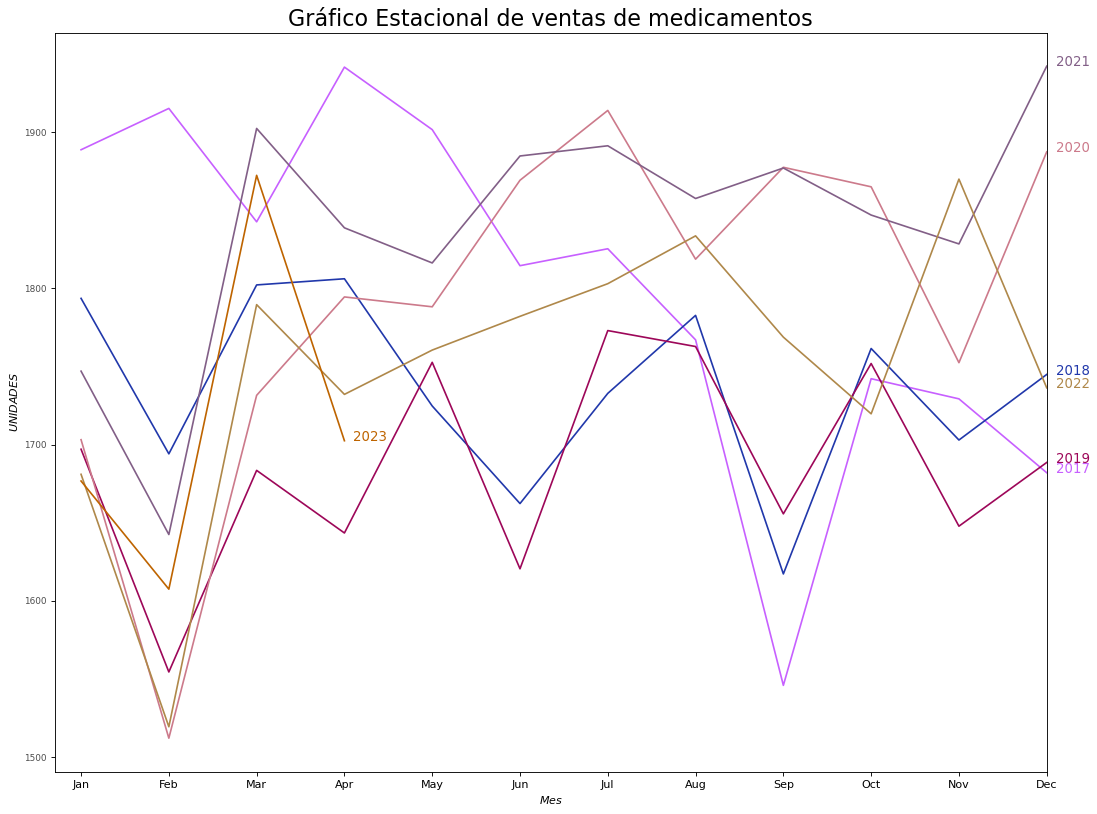

In [21]:
# Ploteamos
plt.figure(figsize=(16,12), dpi= 80)
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'UNIDADES', data=df_ventas.loc[df_ventas.year==y, :], color=mycolors[i], label=y)
        plt.text(df_ventas.loc[df_ventas.year==y, :].shape[0]-.9, df_ventas.loc[df_ventas.year==y, 'UNIDADES'][-1:].values[0], y, fontsize=12, color=mycolors[i])


plt.gca().set(xlim=(-0.3, 11), ylabel='$UNIDADES$', xlabel='$Mes$')
plt.yticks(fontsize=8, alpha=.7)
plt.title("Gráfico Estacional de ventas de medicamentos", fontsize=20);

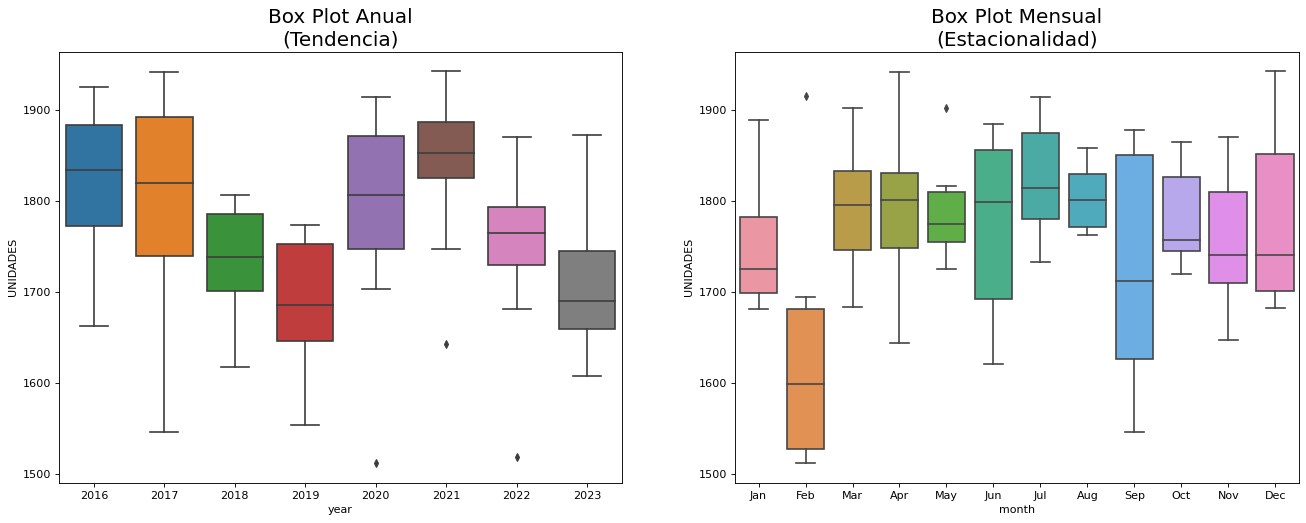

In [22]:
# Definimos los plots:
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='UNIDADES', data=df_ventas, ax=axes[0])
sns.boxplot(x='month', y='UNIDADES', data=df_ventas.loc[~df_ventas.year.isin([2016, 2023]), :])

# Seteamos los títulos:
axes[0].set_title('Box Plot Anual\n(Tendencia)', fontsize=18); 
axes[1].set_title('Box Plot Mensual\n(Estacionalidad)', fontsize=18);

In [23]:
y = df_ventas['UNIDADES'].resample('MS').mean()

<Figure size 1600x1000 with 0 Axes>

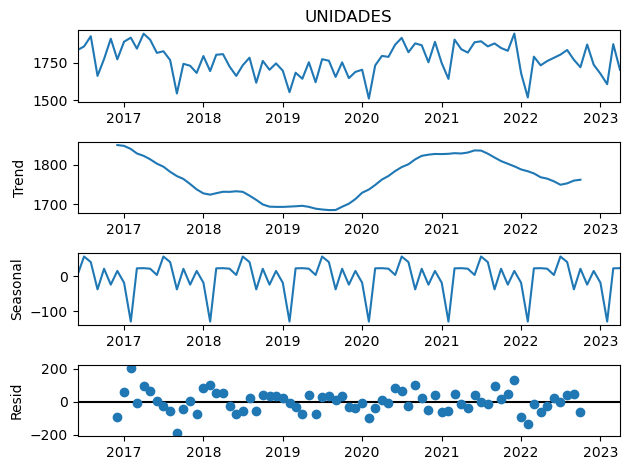

In [24]:
plt.figure(figsize=(16,10))
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
decomposition.plot()
plt.show()

In [25]:
# Dividimos el dataset en train y test. Al ser una serie de tiempo, tenemos que poner shuffle=False 
# (que no mezcle las observaciones), creando una continuidad entre los sets de entrenamiento y de testeo.
df_train, df_test = train_test_split(df_ventas, test_size=12, random_state=42, shuffle=False)

In [26]:
df_ventas.timeIndex.head(3)

#Transformación logarítmica + estacionalidad
# Creamos columna con el mes
df_train['month'] = [d.strftime('%b') for d in df_train.index]
df_test['month']  = [d.strftime('%b') for d in df_test.index]

# Creamos las variables dummies de mes
dummies_mes_train = pd.get_dummies(df_train['month'])
dummies_mes_test = pd.get_dummies(df_test['month'])

# Hacemos el join entre el DataFrame con la serie de tiempo y las dummies
df_train = df_train.join(dummies_mes_train)
df_test = df_test.join(dummies_mes_test)

In [27]:
# Vemos los primeros datos del set de entrenamiento:
df_train.head()

,UNIDADES,timeIndex,timeIndex_sq,year,month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
periodo,,,,,,,,,,,,,,,,,
2016-06-01,1833.352,0,0,2016,Jun,0,0,0,0,0,0,1,0,0,0,0,0
2016-07-01,1857.225,1,1,2016,Jul,0,0,0,0,0,1,0,0,0,0,0,0
2016-08-01,1924.707,2,4,2016,Aug,0,1,0,0,0,0,0,0,0,0,0,0
2016-09-01,1662.422,3,9,2016,Sep,0,0,0,0,0,0,0,0,0,0,0,1
2016-10-01,1773.876,4,16,2016,Oct,0,0,0,0,0,0,0,0,0,0,1,0


In [28]:
# Vemos los últimos datos del set de entrenamiento:
df_train.tail(5)

,UNIDADES,timeIndex,timeIndex_sq,year,month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
periodo,,,,,,,,,,,,,,,,,
2021-12-01,1942.213,66,4356,2021,Dec,0,0,1,0,0,0,0,0,0,0,0,0
2022-01-01,1680.994,67,4489,2022,Jan,0,0,0,0,1,0,0,0,0,0,0,0
2022-02-01,1519.399,68,4624,2022,Feb,0,0,0,1,0,0,0,0,0,0,0,0
2022-03-01,1789.574,69,4761,2022,Mar,0,0,0,0,0,0,0,1,0,0,0,0
2022-04-01,1732.147,70,4900,2022,Apr,1,0,0,0,0,0,0,0,0,0,0,0


In [29]:
# Vemos los primeros datos del set de testeo:
df_test.head(2)

,UNIDADES,timeIndex,timeIndex_sq,year,month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
periodo,,,,,,,,,,,,,,,,,
2022-05-01,1760.497,71,5041,2022,May,0,0,0,0,0,0,0,0,1,0,0,0
2022-06-01,1782.100,72,5184,2022,Jun,0,0,0,0,0,0,1,0,0,0,0,0


In [30]:
# Vemos que hay continuidad entre el set de entrenamiento y el de testeo. Podemos entrenar los modelos con datos hasta 
# abril de 2022 y testear con datos desde mayo en adelante, sin riesgo de data leakage.

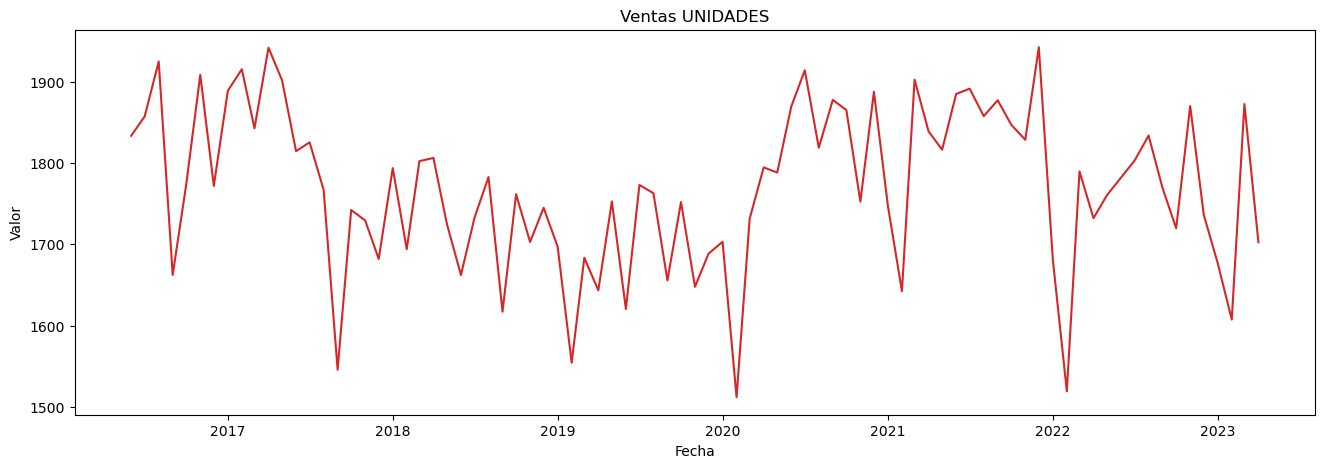

In [31]:
# En el siguiente gráfico podemos ver los datos reales graficados para los periodos Junio 2016 a Abril 2023
plot_df(df_ventas, x=df_ventas.index, y=df_ventas.UNIDADES, title="Ventas UNIDADES")

In [32]:
# Probamos modelos y calculamos la raiz del error cuadrático medio para para comparar los resultados arrojados por 
# dichos modelos

### Modelos básicos para pronósticos

### a. Media Constante

In [33]:
# Comenzamos con el modelo de MEDIA CONSTANTE
# Calculamos el promedio de los datos de train:
model_mean_pred = df_train['UNIDADES'].mean()

# La predicción es fija y es la misma para el set de testeo y de entrenamiento:
df_train["Mean"] = model_mean_pred
df_test["Mean"]  = model_mean_pred

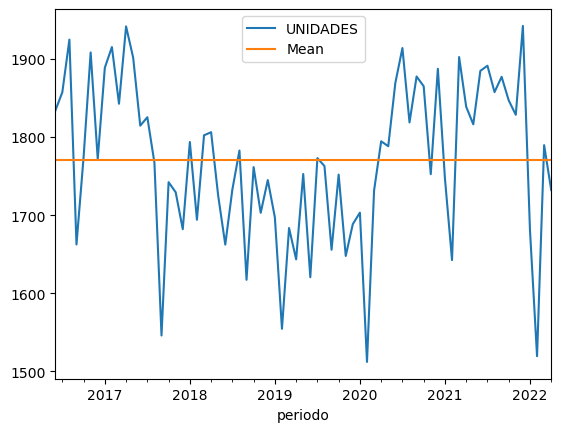

In [34]:
# Ploteamos los valores del set de entrenamiento y el modelo:
df_train.plot(kind="line", y = ["UNIDADES", "Mean"]);

In [35]:
# Calculamos la raiz del error cuadrático medio para el modelo de Media Constante
model_mean_RMSE = RMSE(df_test.Mean, df_test.UNIDADES)
model_mean_RMSE

75.96477076469208

In [36]:
# Guardamos el resultado en un DataFrame:
df_Results = pd.DataFrame(columns = ["Model", "RMSE"])
df_Results.loc[0, "Model"] = "Mean"
df_Results.loc[0, "RMSE"] = model_mean_RMSE
df_Results

,Model,RMSE
0,Mean,75.9648


### b. Random Walk

In [37]:
# Continuamos con el modelo RANDOM WALK
# Generamos el desplazamiento de nuestro nuestro target en el set de entrenamiento (lag=1)
df_train["UNIDADESShift1"] = df_train.UNIDADES.shift()

# La primera observación nos va a quedar en nan, la reemplazamos por el valor siguente:
df_train["UNIDADESShift1"].fillna(method='bfill', inplace=True)
df_train.head()

,UNIDADES,timeIndex,timeIndex_sq,year,month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Mean,UNIDADESShift1
periodo,,,,,,,,,,,,,,,,,,,
2016-06-01,1833.352,0,0,2016,Jun,0,0,0,0,0,0,1,0,0,0,0,0,1770.347268,1833.352
2016-07-01,1857.225,1,1,2016,Jul,0,0,0,0,0,1,0,0,0,0,0,0,1770.347268,1833.352
2016-08-01,1924.707,2,4,2016,Aug,0,1,0,0,0,0,0,0,0,0,0,0,1770.347268,1857.225
2016-09-01,1662.422,3,9,2016,Sep,0,0,0,0,0,0,0,0,0,0,0,1,1770.347268,1924.707
2016-10-01,1773.876,4,16,2016,Oct,0,0,0,0,0,0,0,0,0,0,1,0,1770.347268,1662.422


In [38]:
# Generamos el desplazamiento de nuestro nuestro target en el set de testeo (lag=1):
df_test["UNIDADESShift1"] = df_test.UNIDADES.shift()

In [39]:
# Podemos reemplazar el primer nan con el último valor del set de entrenamiento:
df_test.iloc[0,17] = df_train.iloc[-1,0] 
df_test.head()

,UNIDADES,timeIndex,timeIndex_sq,year,month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Mean,UNIDADESShift1
periodo,,,,,,,,,,,,,,,,,,,
2022-05-01,1760.497,71,5041,2022,May,0,0,0,0,0,0,0,0,1,0,0,0,1732.147000,NaN
2022-06-01,1782.100,72,5184,2022,Jun,0,0,0,0,0,0,1,0,0,0,0,0,1770.347268,1760.497
2022-07-01,1802.996,73,5329,2022,Jul,0,0,0,0,0,1,0,0,0,0,0,0,1770.347268,1782.100
2022-08-01,1833.605,74,5476,2022,Aug,0,1,0,0,0,0,0,0,0,0,0,0,1770.347268,1802.996
2022-09-01,1768.775,75,5625,2022,Sep,0,0,0,0,0,0,0,0,0,0,0,1,1770.347268,1833.605


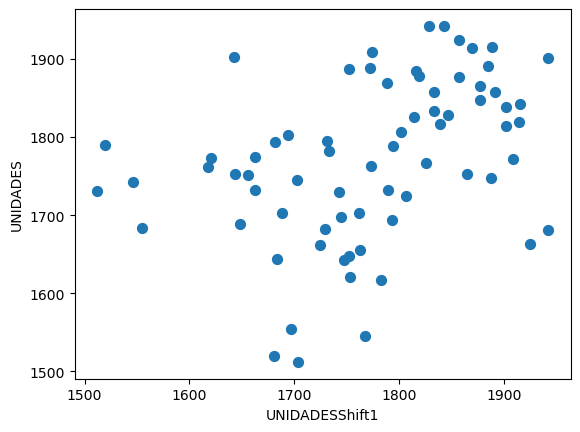

In [40]:
# Vamos a hacer un scatterplot entre las observaciones y su lag de un período:
df_train.plot(kind= "scatter", y = "UNIDADES", x = "UNIDADESShift1", s = 50);

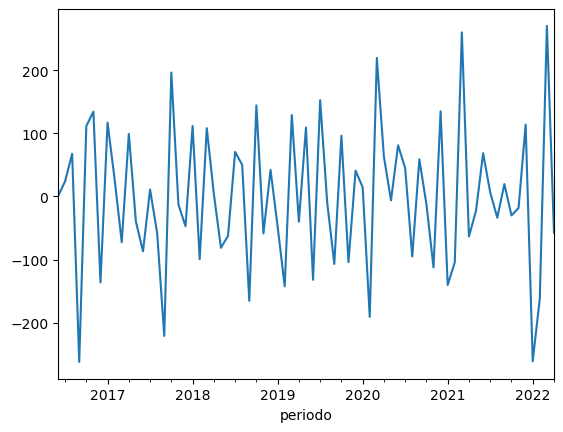

In [41]:
# Ploteamos la diferencia entre nuestro target y el lag de un período:
df_train["UNIDADESDiff"] = df_train.UNIDADES - df_train.UNIDADESShift1
df_train.UNIDADESDiff.plot();

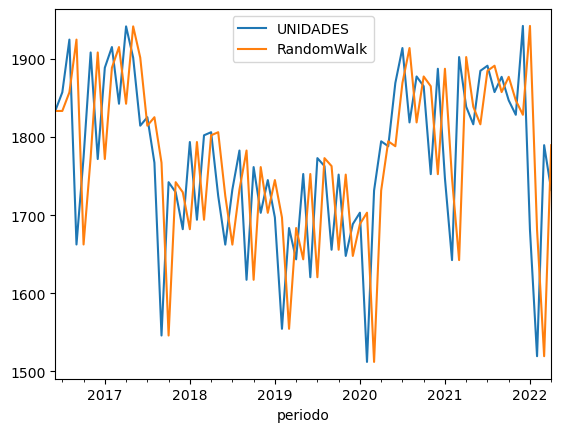

In [42]:
df_train["RandomWalk"] = df_train.UNIDADESShift1
df_train.plot(kind="line", y = ["UNIDADES", "RandomWalk"]);

In [43]:
# La predicción sobre el set de testeo es simplemente la última observación registrada en el set de entrenamiento.
df_test["RandomWalk"] = pd.Series(df_train["UNIDADES"][-1], index=df_test.index)

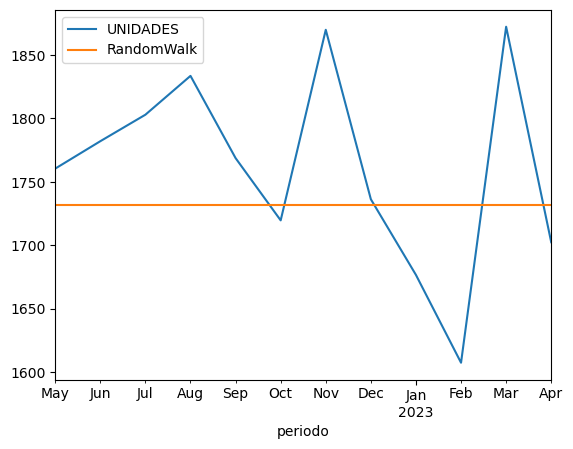

In [44]:
# Visualmente ya se observa que el método no predice correctamente
df_test.plot(kind="line", y = ["UNIDADES", "RandomWalk"]);

In [45]:
# Calculamos el RMSE y almacenamos los resultados
df_Results = actualizar_reporte_resultados(df_Results,"Random Walk",df_test.RandomWalk,df_test.UNIDADES)
df_Results

,Model,RMSE
0,Mean,75.9648
1,Random Walk,80.7576


In [46]:
# Vemos que tomar la última observación del set de entranamiento no mejoró nuestras predicciones 
# en el set de testeo respecto a tomar la media de todo el dataset.

### c. Tendencia Lineal

In [47]:
# Continuamos con el modelo de Tendencia Lineal
# Continuaremos trabajando con la tendencia lineal entre value y time, fiteando nuestro modelo de regresión lineal 
# entre "UNIDADES" y "timeIndex". 
model_linear = smf.ols('UNIDADES ~ timeIndex', data = df_train).fit()

In [48]:
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               UNIDADES   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                   0.01128
Date:                Mon, 26 Jun 2023   Prob (F-statistic):              0.916
Time:                        21:40:33   Log-Likelihood:                -429.41
No. Observations:                  71   AIC:                             862.8
Df Residuals:                      69   BIC:                             867.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1772.5841     24.402     72.640      0.000    1723.903    1821.265
timeIndex     -0.0639      0.602     -0.106      0.916      -1.264       1.136
==============================================================================
Omnibus:                        2.697   Durbin-Watson:                   1.238
Prob(Omnibus):                  0.260   Jarque-Bera (JB):                2.639
Skew:                          -0.450   Prob(JB):                        0.267
Kurtosis:                       2.712   Cond. No.                         80.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
# Veamos las predicciones del modelo sobre el set de entrenamiento:
df_train["LinearTrend"] = model_linear.predict(df_train.timeIndex)

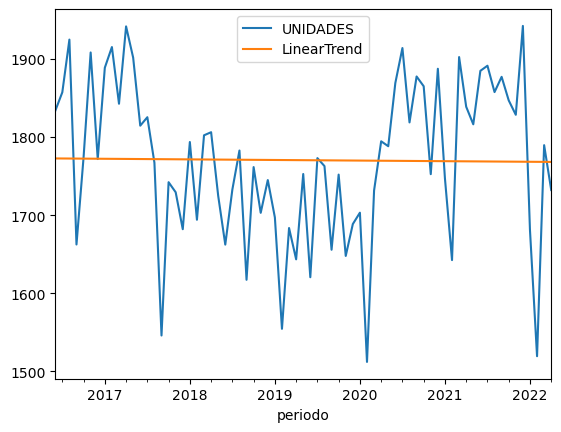

In [50]:
# Ploteamos los resultados de la predicción:
df_train.plot(kind = "line", y = ["UNIDADES","LinearTrend"]);

In [51]:
# Veamos las predicciones del modelo sobre el set de testeo:
df_test["LinearTrend"] = model_linear.predict(df_test.timeIndex)

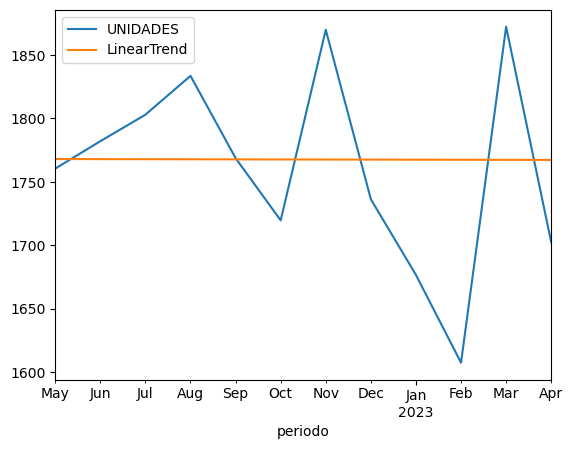

In [52]:
# Ploteamos los resultados de la predicción:
df_test.plot(kind = "line", y = ["UNIDADES","LinearTrend"]);

In [53]:
# Calculamos el error y añadimos estos datos a nuestro DF de resultados para comparar con el modelo anterior:
df_Results = actualizar_reporte_resultados(df_Results,"LinearTrend",df_test.LinearTrend,df_test.UNIDADES)
df_Results

,Model,RMSE
0,Mean,75.9648
1,Random Walk,80.7576
2,LinearTrend,75.6195


In [54]:
# Vemos que en este caso la tendencia lineal logra reducir el RMSE en el set de testeo.

### d. Tendencia cuadrática

In [55]:
# Continuaremos trabajando con la tendencia cuadrática entre UNIDADES y time:
# Ahora fiteamos nuestro modelo de regresión lineal entre UNIDADES y timeIndex + timeIndex_sq
model_quadratic = smf.ols('UNIDADES ~ timeIndex + timeIndex_sq', data = df_train).fit()

In [56]:
# Observamos el summary del modelo:
model_quadratic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               UNIDADES   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     5.664
Date:                Mon, 26 Jun 2023   Prob (F-statistic):            0.00531
Time:                        21:40:34   Log-Likelihood:                -423.95
No. Observations:                  71   AIC:                             853.9
Df Residuals:                      68   BIC:                             860.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1855.5053     33.552     55.302      0.000    1788.553    1922.458
timeIndex       -7.2744      2.216     -3.283      0.002     -11.696      -2.853
timeIndex_sq     0.1030      0.031      3.364      0.001       0.042       0.164
==============================================================================
Omnibus:                       10.273   Durbin-Watson:                   1.445
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.129
Skew:                          -0.833   Prob(JB):                      0.00632
Kurtosis:                       3.803   Cond. No.                     6.47e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.47e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [57]:
# Vemos que la componente cuadrática es significativa, ya que también tiene un p-valor cercano a cero. 
# Podemos ver además que tanto el AIC como el BIC se redujeron, corroborando una mejor bondad de ajuste.

In [58]:
# Veamos las predicciones del modelo sobre el set de entrenamiento:
df_train["QuadraticTrend"] = model_quadratic.predict(df_train[["timeIndex",\
                                                      "timeIndex_sq"]])

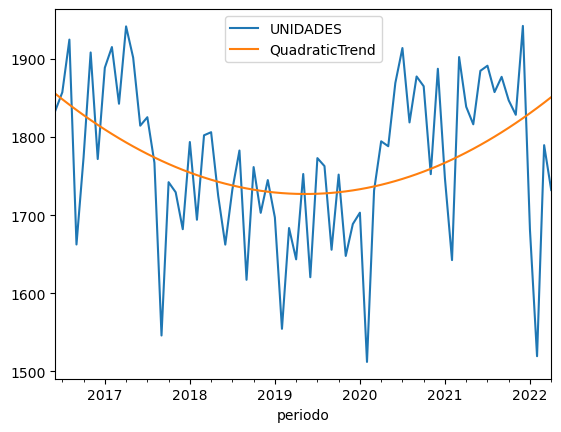

In [59]:
# Ploteamos los resultados de la predicción:
df_train.plot(kind = "line", y = ["UNIDADES","QuadraticTrend"]);

In [60]:
# Veamos las predicciones del modelo sobre el set de testeo:
df_test["QuadraticTrend"] = model_quadratic.predict(df_test[["timeIndex",\
                                                      "timeIndex_sq"]])

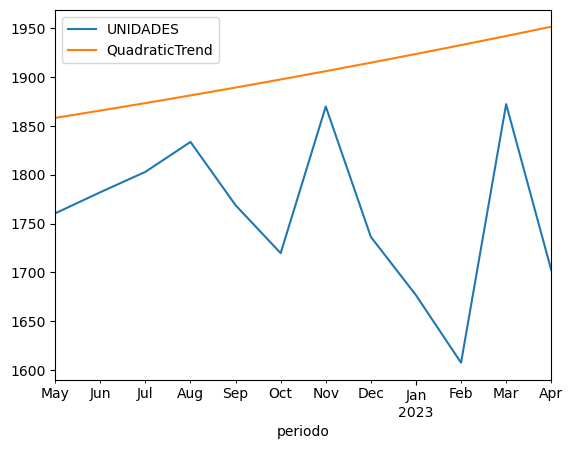

In [61]:
# Ploteamos los resultados de la predicción:
df_test.plot(kind = "line", y = ["UNIDADES", "QuadraticTrend"]);

In [62]:
# Añadimos estos datos a nuestro DF de resultados para comparar con el modelo anterior
df_Results = actualizar_reporte_resultados(df_Results,"QuadraticTrend",df_test.QuadraticTrend,df_test.UNIDADES)
df_Results

,Model,RMSE
0,Mean,75.9648
1,Random Walk,80.7576
2,LinearTrend,75.6195
3,QuadraticTrend,167.559


In [63]:
# Calculamos la performance con RMSE. En este dataset, sigue ajustando mejor la tendencia lineal.

### e. Tendencia con transformación logarítmica

In [64]:
df_train['log_value'] = np.log(df_train['UNIDADES'])
df_test['log_value'] = np.log(df_test['UNIDADES'])

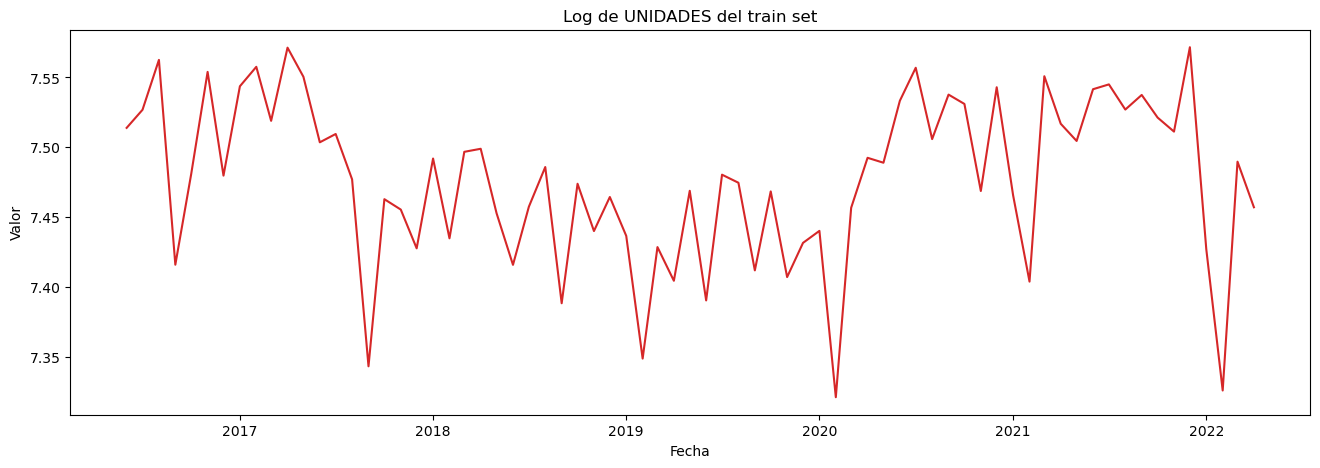

In [65]:
plot_df(df_train, x=df_train.index, y=df_train['log_value'],\
    title='Log de UNIDADES del train set')

In [66]:
df_train.head()

,UNIDADES,timeIndex,timeIndex_sq,year,month,Apr,Aug,Dec,Feb,Jan,...,Nov,Oct,Sep,Mean,UNIDADESShift1,UNIDADESDiff,RandomWalk,LinearTrend,QuadraticTrend,log_value
periodo,,,,,,,,,,,,,,,,,,,,,
2016-06-01,1833.352,0,0,2016,Jun,0,0,0,0,0,...,0,0,0,1770.347268,1833.352,0.000,1833.352,1772.584054,1855.505272,7.513901
2016-07-01,1857.225,1,1,2016,Jul,0,0,0,0,0,...,0,0,0,1770.347268,1833.352,23.873,1833.352,1772.520146,1848.333831,7.526839
2016-08-01,1924.707,2,4,2016,Aug,0,1,0,0,0,...,0,0,0,1770.347268,1857.225,67.482,1857.225,1772.456238,1841.368405,7.562529
2016-09-01,1662.422,3,9,2016,Sep,0,0,0,0,0,...,0,0,1,1770.347268,1924.707,-262.285,1924.707,1772.392329,1834.608995,7.416031
2016-10-01,1773.876,4,16,2016,Oct,0,0,0,0,0,...,0,1,0,1770.347268,1662.422,111.454,1662.422,1772.328421,1828.055600,7.480922


In [67]:
# Ahora fiteamos nuestro modelo de regresión lineal entre log_value y timeIndex
model_log = smf.ols('log_value ~ timeIndex ', data = df_train).fit()

In [68]:
# Veamos las predicciones:
df_train['model_log'] = model_log.predict(df_train[["timeIndex"]])
df_test['model_log'] = model_log.predict(df_test[["timeIndex"]])

In [69]:
# Veamos el summary del modelo:
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_value   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                   0.01616
Date:                Mon, 26 Jun 2023   Prob (F-statistic):              0.899
Time:                        21:40:36   Log-Likelihood:                 100.40
No. Observations:                  71   AIC:                            -196.8
Df Residuals:                      69   BIC:                            -192.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.4788      0.014    533.504      0.000       7.451       7.507
timeIndex  -4.393e-05      0.000     -0.127      0.899      -0.001       0.001
==============================================================================
Omnibus:                        4.359   Durbin-Watson:                   1.266
Prob(Omnibus):                  0.113   Jarque-Bera (JB):                4.090
Skew:                          -0.587   Prob(JB):                        0.129
Kurtosis:                       2.941   Cond. No.                         80.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [70]:
# Almacenamos las predicciones del modelo en el set de entrenamiento y testeo luego de haber realizado back-transformation:
df_train['back_model_log'] = np.exp(df_train['model_log'])
df_test['back_model_log'] = np.exp(df_test['model_log'])

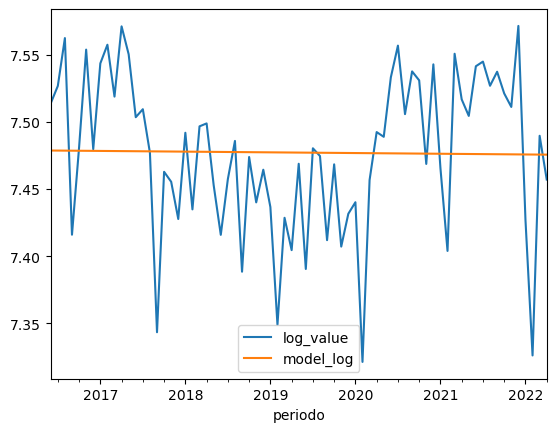

In [71]:
# Ploteamos los resultados de la predicción en el set de entrenamiento sin back-transformation:
df_train.plot(kind = "line", y = ['log_value', 'model_log']);

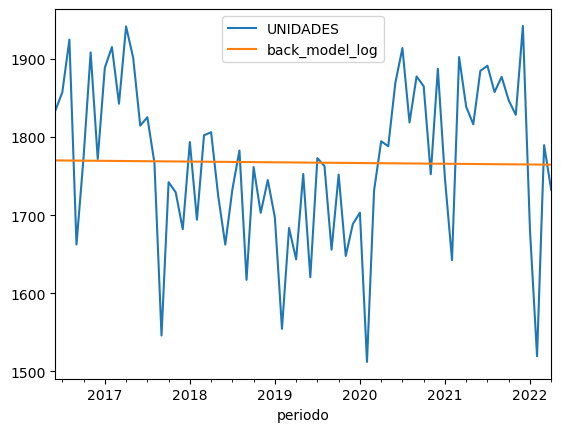

In [72]:
# Ploteamos los resultados de la predicción en el set de entrenamiento con back-transformation:
df_train.plot(kind = "line", y = ['UNIDADES', 'back_model_log']);

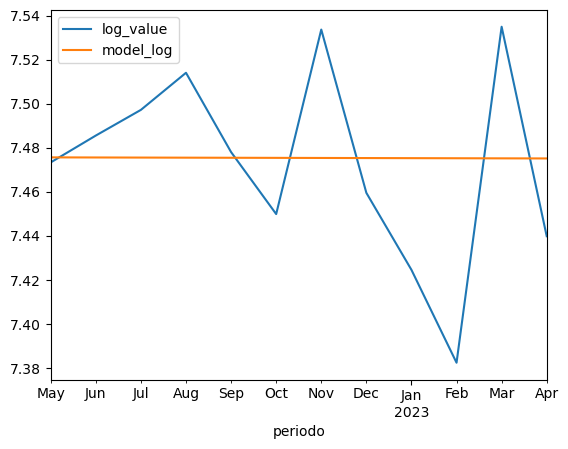

In [73]:
# Ploteamos los resultados de la predicción en el set de testeo sin back-transformation:
df_test.plot(kind = "line", y = ['log_value', 'model_log']);

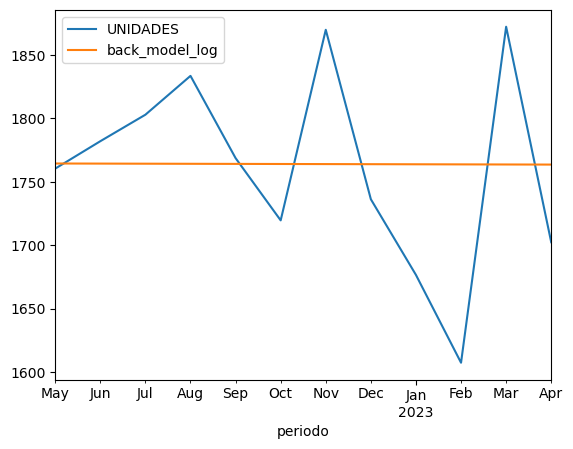

In [74]:
# Ploteamos los resultados de la predicción en el set de testeo con back-transformation:
df_test.plot(kind = "line", y = ['UNIDADES', 'back_model_log']);

In [75]:
# Añadimos estos datos a nuestro DF de resultados para comparar con el modelo anterior:
df_Results = actualizar_reporte_resultados(df_Results,"Transf Log",df_test['back_model_log'],df_test.UNIDADES)
df_Results

,Model,RMSE
0,Mean,75.9648
1,Random Walk,80.7576
2,LinearTrend,75.6195
3,QuadraticTrend,167.559
4,Transf Log,75.3758


In [76]:
# Vemos una mejoría en el RMSE con el modelo logarítmico.

### f. Tendencia con transformación logarítmica + estacionalidad mensual:

In [77]:
# Ahora fiteamos nuestro modelo de regresión lineal entre log_value y timeIndex más las dummies de mes:
model_log_est = smf.ols('log_value ~ timeIndex + Apr + Aug + Dec + Feb + Jan + Jul + Jun + Mar + May + Nov + Oct + Sep',\
                          data = df_train).fit()

In [78]:
model_log_est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_value   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     1.687
Date:                Mon, 26 Jun 2023   Prob (F-statistic):             0.0936
Time:                        21:40:39   Log-Likelihood:                 111.02
No. Observations:                  71   AIC:                            -196.0
Df Residuals:                      58   BIC:                            -166.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.9016      0.012    562.988      0.000       6.877       6.926
timeIndex   2.114e-05      0.000      0.064      0.949      -0.001       0.001
Apr            0.5878      0.022     26.627      0.000       0.544       0.632
Aug            0.6033      0.022     27.508      0.000       0.559       0.647
Dec            0.5840      0.022     26.590      0.000       0.540       0.628
Feb            0.4964      0.022     22.554      0.000       0.452       0.540
Jan            0.5652      0.022     25.709      0.000       0.521       0.609
Jul            0.6105      0.022     27.832      0.000       0.567       0.654
Jun            0.5809      0.022     26.474      0.000       0.537       0.625
Mar            0.5879      0.022     26.674      0.000       0.544       0.632
May            0.5908      0.024     24.740      0.000       0.543       0.639
Nov            0.5705      0.022     25.992      0.000       0.527       0.614
Oct            0.5875      0.022     26.779      0.000       0.544       0.631
Sep            0.5369      0.022     24.481      0.000       0.493       0.581
==============================================================================
Omnibus:                        3.285   Durbin-Watson:                   0.983
Prob(Omnibus):                  0.194   Jarque-Bera (JB):                2.709
Skew:                           0.473   Prob(JB):                        0.258
Kurtosis:                       3.142   Cond. No.                     2.47e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.92e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [79]:
# Vemos al agregar las dummies mensuales, los coeficientes de todos los meses son significativos.

In [80]:
# Calculamos las predicciones:
df_train['model_log_est'] = model_log_est.predict(df_train[["timeIndex",'Apr' , 'Aug' , 'Dec' , \
                                                            'Feb' , 'Jan' , 'Jul' , 'Jun' , 'Mar' , \
                                                            'May', 'Nov', 'Oct', 'Sep']])


df_test['model_log_est'] = model_log_est.predict(df_test[["timeIndex",'Apr' , 'Aug' , 'Dec' , \
                                                            'Feb' , 'Jan' , 'Jul' , 'Jun' , 'Mar' , \
                                                            'May', 'Nov', 'Oct', 'Sep']])

In [81]:
# Almacenamos las predicciones del modelo en el set de entrenamiento y testeo luego de haber realizado back-transformation:
df_train['back_model_log_est'] = np.exp(df_train['model_log_est'])
df_test['back_model_log_est'] = np.exp(df_test['model_log_est'])

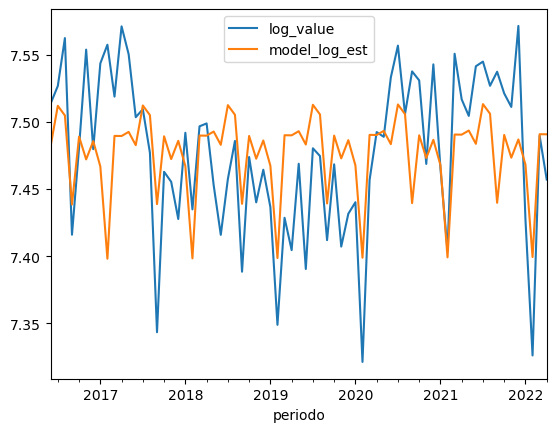

In [82]:
# Ploteamos los resultados de la predicción en el set de entrenamiento sin back-transformation:
df_train.plot(kind = "line", y = ['log_value', 'model_log_est']);

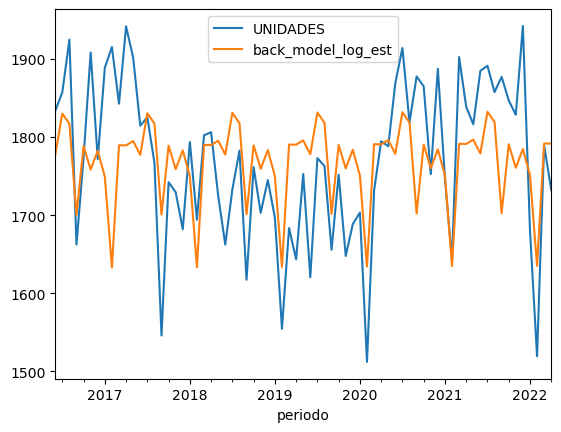

In [83]:
# Ploteamos los resultados de la predicción en el set de entrenamiento con back-transformation:
df_train.plot(kind = "line", y = ['UNIDADES', 'back_model_log_est']);    

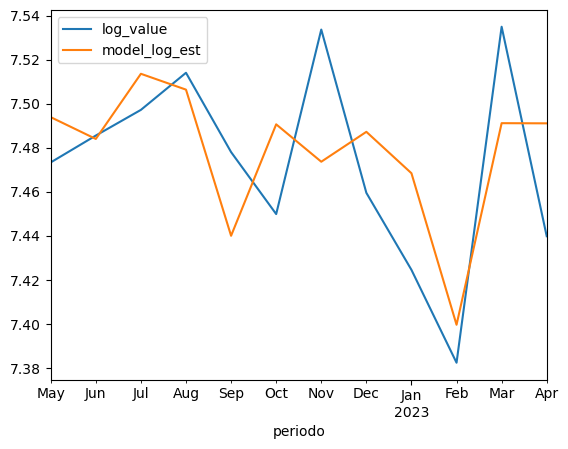

In [84]:
# Ploteamos los resultados de la predicción en el set de testeo sin back-transformation:
df_test.plot(kind = "line", y = ['log_value', 'model_log_est']);

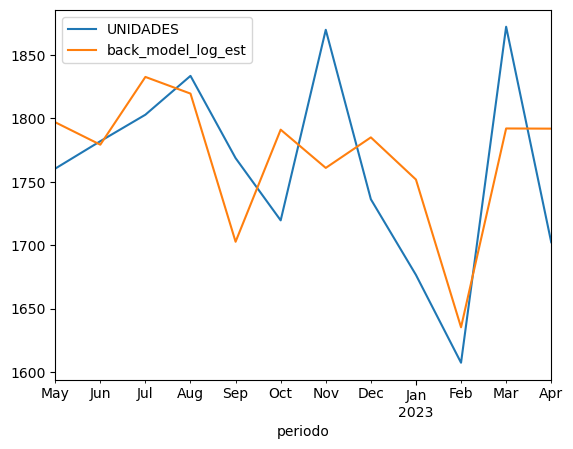

In [85]:
# Ploteamos los resultados de la predicción en el set de testeo con back-transformation:
df_test.plot(kind = "line", y = ['UNIDADES', 'back_model_log_est']);

In [86]:
df_Results = actualizar_reporte_resultados(df_Results,"Log + Est",df_test.back_model_log_est,df_test.UNIDADES)
df_Results

,Model,RMSE
0,Mean,75.9648
1,Random Walk,80.7576
2,LinearTrend,75.6195
3,QuadraticTrend,167.559
4,Transf Log,75.3758
5,Log + Est,62.5805


In [87]:
# Vemos que al modelar la estacionalidad mensual agregando las variables dummy, nuestro modelos mejora sustancialmente, 
# reduciéndose el RMSE de 75.37 a 62.58.

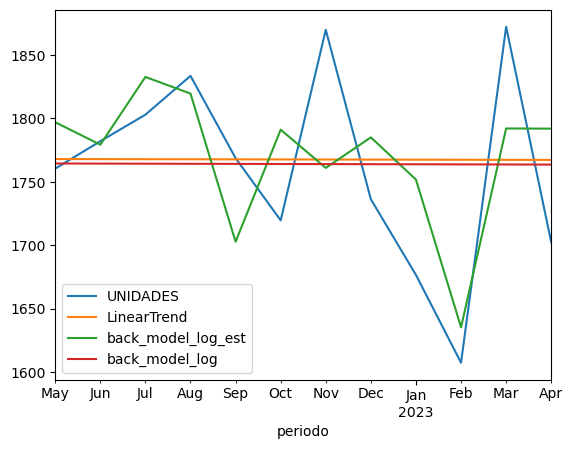

In [88]:
# Ploteamos las mejores estimaciones 
df_test.plot(kind = "line", y = ["UNIDADES", "LinearTrend", "back_model_log_est",\
                                                 "back_model_log"]);

### Modelos de Ciclos para Series de Tiempo

In [89]:
# Vamos a calcular los residuos del mejor modelo que tenemos hasta ahora, el modelo con transformación logarítmica y dummies 
# estacionales.

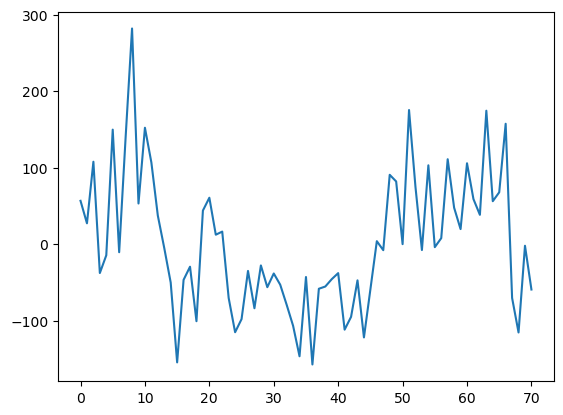

In [90]:
# Probamos primero si los residuos del modelo en la serie original son estacionarios:
residuo = df_train['UNIDADES'] - df_train['back_model_log_est']
plt.plot(df_train.timeIndex, residuo, '-');

In [91]:
# Aplicamos el test de Dickey-Fuller al residuo:
result = adfuller(residuo)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

ADF Statistic: -1.909686
p-value: 0.327519
Valor crítico 1%: -3.54
Valor crítico 5%: -2.91
Valor crítico 10%: -2.59


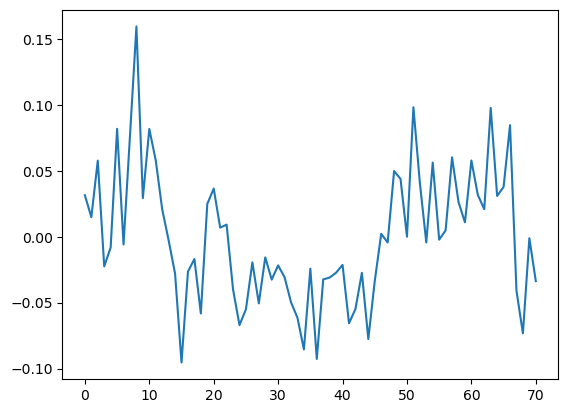

In [92]:
# No podemos rechazar la  𝐻0 con un nivel de significación del 32%. 
# Probamos ahora con los residuos antes de realizar back transform:
res_log_est = df_train['log_value'] - df_train['model_log_est']
plt.plot(df_train.timeIndex, res_log_est, '-');

In [93]:
# Aplicamos el test de Dickey-Fuller al residuo:
result = adfuller(res_log_est)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

ADF Statistic: -1.901890
p-value: 0.331172
Valor crítico 1%: -3.54
Valor crítico 5%: -2.91
Valor crítico 10%: -2.59


In [94]:
# Tampoco podemos rechazar la  𝐻0 con un nivel de significación del 33%.

In [95]:
# Entonces analizamos la serie diferenciada
residuo.diff().dropna()

periodo
2016-07-01    -29.457504
2016-08-01     80.599937
2016-09-01   -145.670205
2016-10-01     23.234611
2016-11-01    164.445919
                 ...    
2021-12-01     89.701124
2022-01-01   -227.979813
2022-02-01    -45.179377
2022-03-01    113.502435
2022-04-01    -57.293381
Length: 70, dtype: float64

In [96]:
# Aplicamos el test de Dickey-Fuller al residuo diferenciado:
result = adfuller(residuo.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

ADF Statistic: -3.245621
p-value: 0.017491
Valor crítico 1%: -3.54
Valor crítico 5%: -2.91
Valor crítico 10%: -2.59


In [97]:
# Podemos rechazar la  𝐻0. Avanzamos con el modelado de los ciclos de los residuos del modelo:

<AxesSubplot:title={'center':'Density'}, ylabel='Density'>

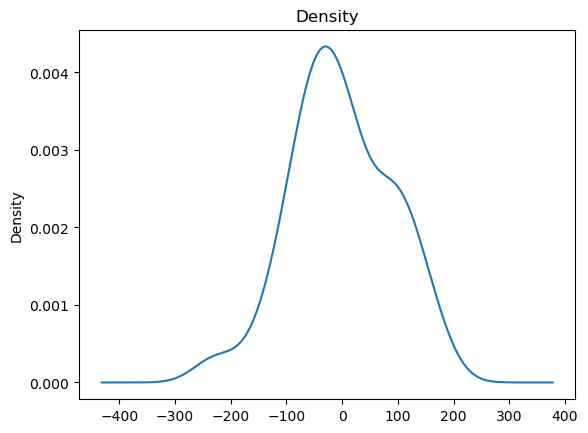

In [98]:
residuo.diff().dropna().plot(kind='kde', title='Density')

### a. Modelo ARIMA

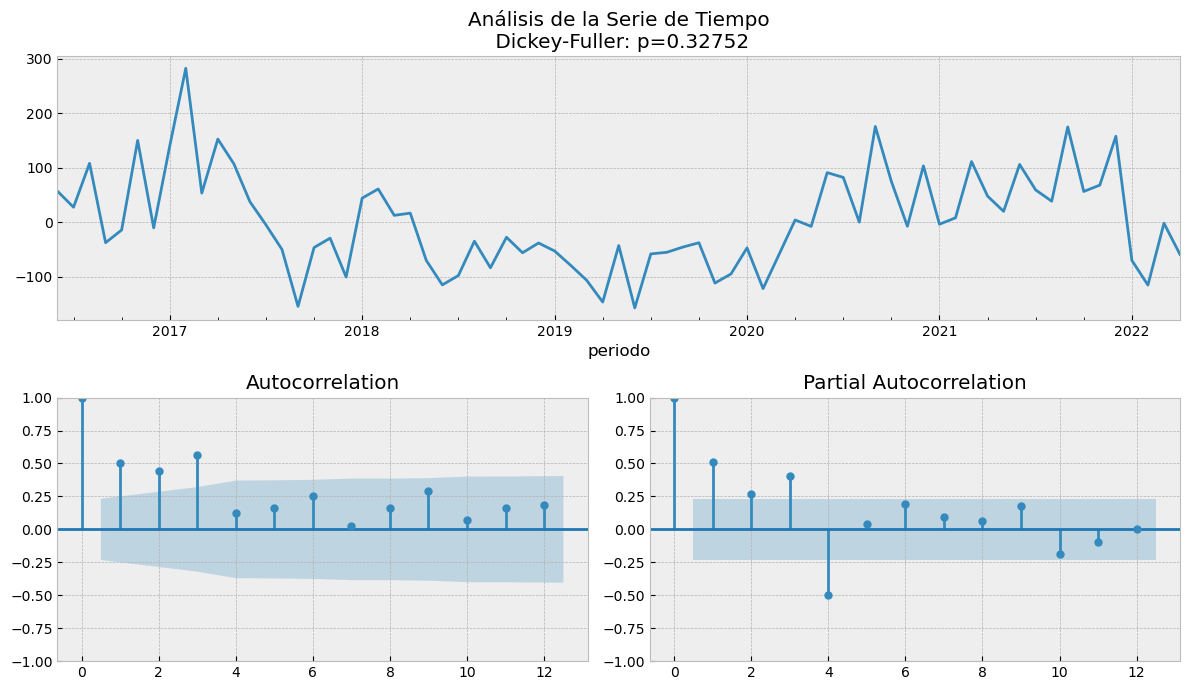

In [99]:
# Corremos la función con nuestra serie residuo:
tsplot(residuo, lags=12)

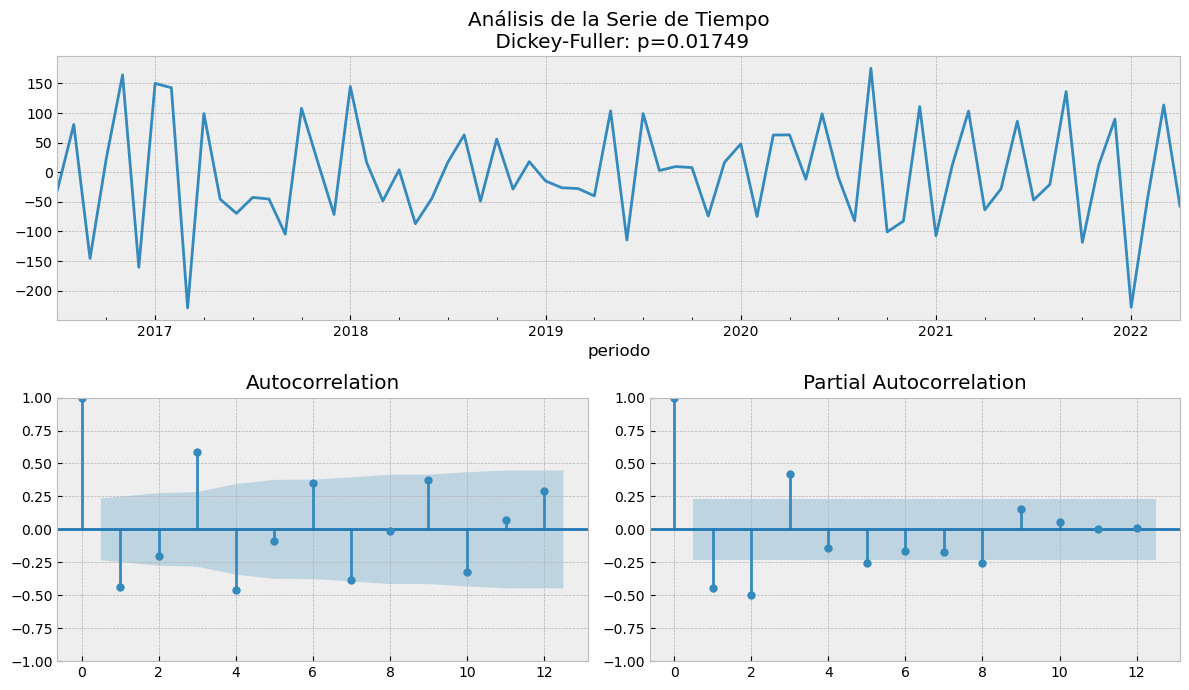

In [100]:
# Corremos la función con nuestra serie residuo diferenciada:
tsplot(residuo.diff().dropna(), lags=12)

In [101]:
# Instancio el modelo con parámetros que nos dieron el mejor rendimiento
model_ARIMA = ARIMA(residuo, order=(3,1,2))  #para el filtro psicofarmacos general

# Estimamos el modelo:
results_ARIMA = model_ARIMA.fit()
results_ARIMA.fittedvalues.head(10)

periodo
2016-06-01      0.000000
2016-07-01     56.465810
2016-08-01     40.003810
2016-09-01     69.705297
2016-10-01     -6.036259
2016-11-01     42.217024
2016-12-01     17.846400
2017-01-01     46.367406
2017-02-01    183.336020
2017-03-01    128.860792
dtype: float64

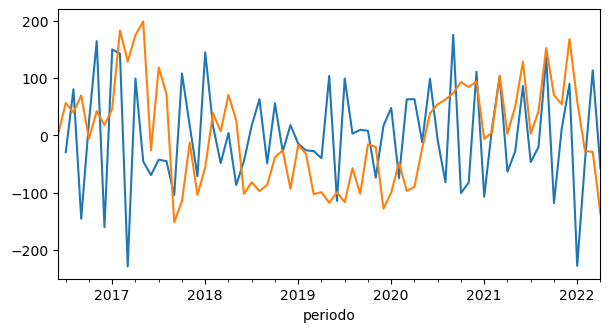

In [102]:
plt.figure(figsize=(7,3.5))
residuo.diff().dropna().plot()
results_ARIMA.fittedvalues.plot();

In [103]:
# Analizamos los residuos del modelo ARIMA:
res_ARIMA_b =  results_ARIMA.resid  

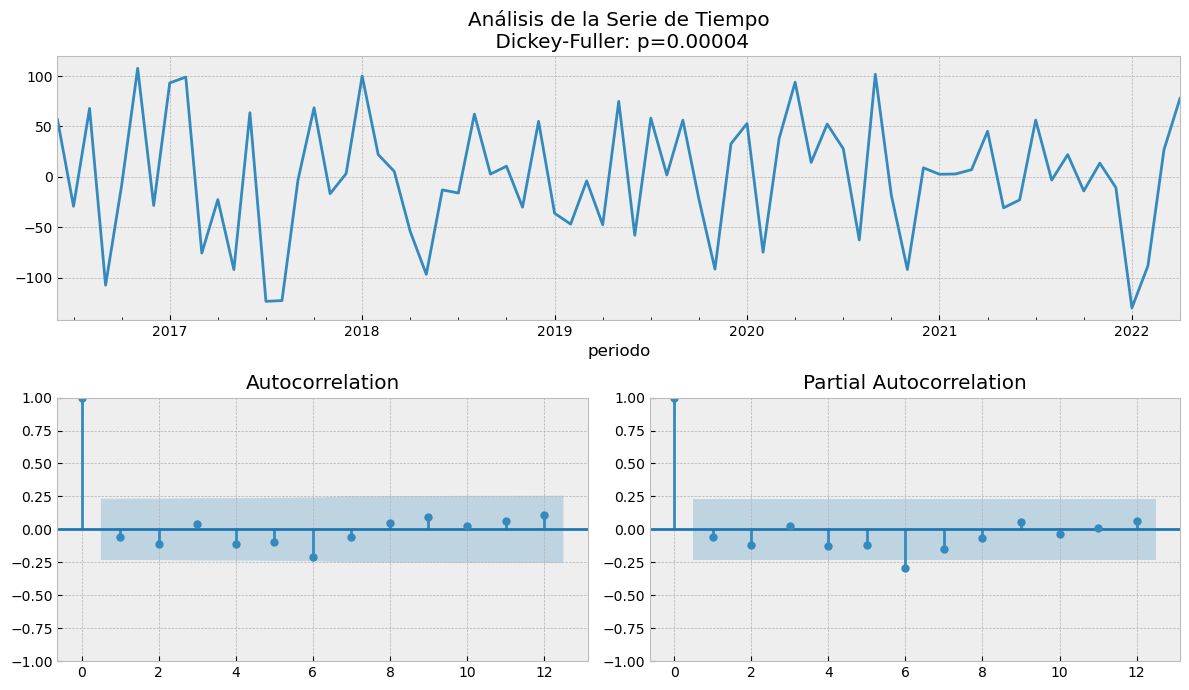

In [104]:
tsplot(res_ARIMA_b, lags=12)

In [105]:
# No parecería haber más estructura en los resíduos que podamos capturar. Nuestro resíduo ahora es ruido blanco.

<AxesSubplot:title={'center':'Density'}, ylabel='Density'>

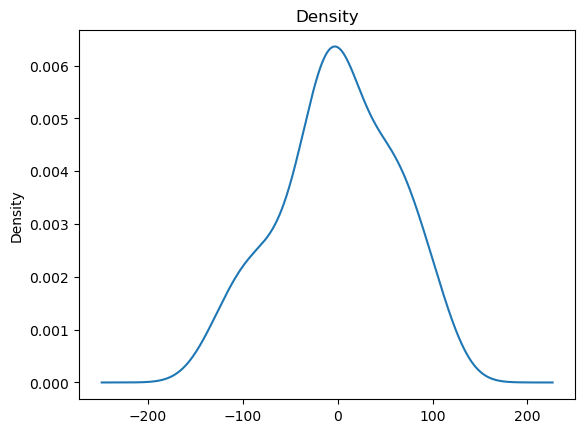

In [106]:
results_ARIMA.resid.plot(kind='kde', title='Density')

In [107]:
predictions_ARIMA = results_ARIMA.forecast(len(df_test['UNIDADES']))

In [108]:
results_ARIMA.fittedvalues

periodo
2016-06-01      0.000000
2016-07-01     56.465810
2016-08-01     40.003810
2016-09-01     69.705297
2016-10-01     -6.036259
                 ...    
2021-12-01    168.213597
2022-01-01     59.590217
2022-02-01    -27.303053
2022-03-01    -28.936224
2022-04-01   -137.221160
Length: 71, dtype: float64

In [109]:
# Incorporamos el efecto cíclico a nuestro modelo
df_train['model_ARIMA'] = df_train['back_model_log_est'] + results_ARIMA.fittedvalues 

df_test['model_ARIMA'] = df_test['back_model_log_est'] + predictions_ARIMA 

<AxesSubplot:xlabel='periodo'>

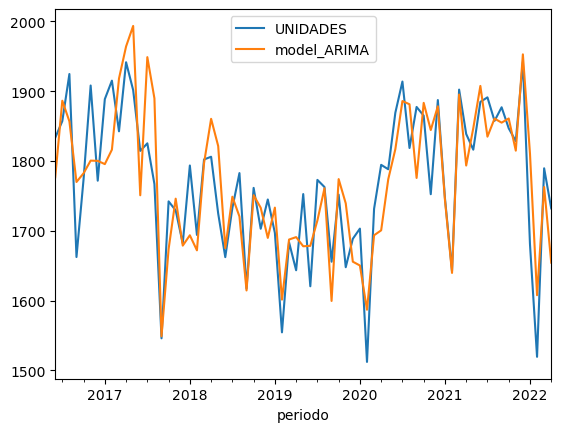

In [110]:
df_train.plot(kind = "line", y = ['UNIDADES', 'model_ARIMA'])

<AxesSubplot:xlabel='periodo'>

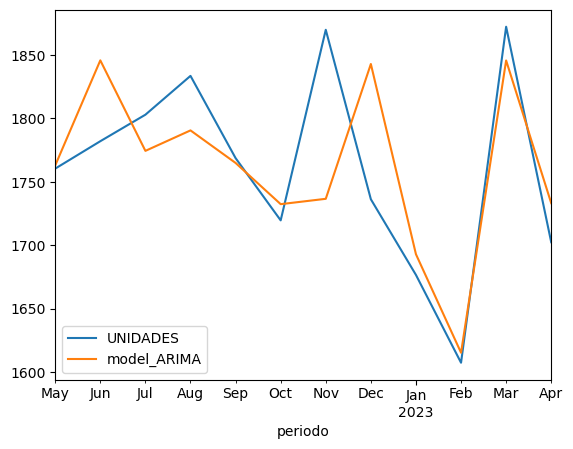

In [111]:
df_test.plot(kind = "line", y = ['UNIDADES', 'model_ARIMA'])

In [112]:
# Evaluamos el modelo.
df_Results = actualizar_reporte_resultados(df_Results,"Log + Est + ARIMA",df_test['model_ARIMA'],df_test.UNIDADES)
df_Results

,Model,RMSE
0,Mean,75.9648
1,Random Walk,80.7576
2,LinearTrend,75.6195
3,QuadraticTrend,167.559
4,Transf Log,75.3758
5,Log + Est,62.5805
6,Log + Est + ARIMA,56.2781


In [113]:
# Vemos que el modelo que combina la tendencia, la estacionalidad y el ciclo es el que performa mejor de todos

In [114]:
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   71
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -385.119
Date:                Mon, 26 Jun 2023   AIC                            782.239
Time:                        21:40:50   BIC                            795.729
Sample:                    06-01-2016   HQIC                           787.597
                         - 04-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9891      0.145     -6.835      0.000      -1.273      -0.705
ar.L2         -0.9425      0.155     -6.093      0.000      -1.246      -0.639
ar.L3          0.0250      0.145      0.173      0.863      -0.258       0.308
ma.L1          0.6821      0.084      8.077      0.000       0.517       0.848
ma.L2          0.8837      0.090      9.784      0.000       0.707       1.061
sigma2      3322.0414    705.993      4.705      0.000    1938.321    4705.762
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 1.59
Prob(Q):                              0.77   Prob(JB):                         0.45
Heteroskedasticity (H):               0.61   Skew:                            -0.23
Prob(H) (two-sided):                  0.25   Kurtosis:                         2.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

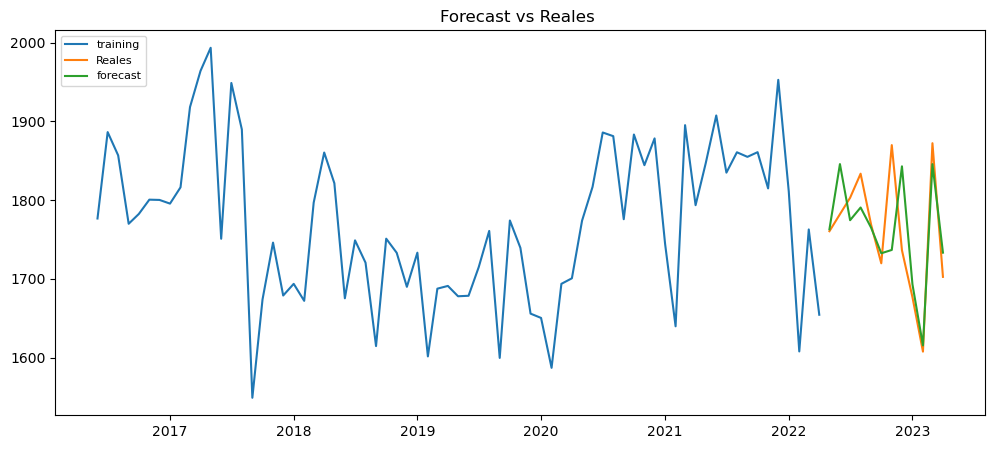

In [115]:
#Vemos en un mismo gráfico valores de entrenamiento del modelo, datos reales y predicciones del modelo
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train['model_ARIMA'], label='training')
plt.plot(df_test.UNIDADES, label='Reales')
plt.plot(df_test['model_ARIMA'], label='forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color='k', alpha=.15)
plt.title('Forecast vs Reales ')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [116]:
# Inicio búsqueda de mejores parámetros ARIMA------------------------------------------------------------------#

In [117]:
p_values = range(0, 4)
d_values = 1
q_values = range(0, 4)

grid_cant_lineas = 0

df_Results_grid = pd.DataFrame(columns = ["Order", "RMSE"])

for p in p_values:
    for q in q_values:
        grid_order = (p,1,q)
        grid_model_ARIMA       = ARIMA(residuo, order=grid_order)  #para el filtro psicofarmacos general
        grid_results_ARIMA     = grid_model_ARIMA.fit()
        grid_predictions_ARIMA = grid_results_ARIMA.forecast(len(df_test['UNIDADES']))  
        df_test['model_ARIMA_grid'] = df_test['back_model_log_est'] + grid_predictions_ARIMA         
        grid_cant_lineas = grid_cant_lineas + 1
        df_Results_grid.loc[grid_cant_lineas, "Order"] = grid_order
        df_Results_grid.loc[grid_cant_lineas, "RMSE"] = RMSE(df_test['model_ARIMA_grid'],df_test.UNIDADES)      

In [118]:
df_Results_grid.sort_values(by='RMSE')

,Order,RMSE
15,"(3, 1, 2)",56.2781
11,"(2, 1, 2)",56.6741
12,"(2, 1, 3)",57.1426
16,"(3, 1, 3)",59.4707
14,"(3, 1, 1)",63.8868
7,"(1, 1, 2)",64.3116
8,"(1, 1, 3)",64.8418
2,"(0, 1, 1)",67.0178
13,"(3, 1, 0)",68.9653
10,"(2, 1, 1)",69.1232


In [119]:
# Fin búsqueda de mejores parámetros ARIMA------------------------------------------------------------------------#